In [24]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [25]:
from nlinec import get_positive_data, get_all_types, get_results_dir, get_type, color_palette, get_models_dir
from nlinec.data.preprocessing import get_granularity

## Parameters

In [26]:
granularities = ['Coarse', 'Medium', 'Fine']

In [27]:
models = os.listdir(get_models_dir())
print(models)

['nlinec-E-2', 'nlinec-C-2', 'nlinec-D-1', 'nlinec-D-2', 'nlinec-D-3']


In [28]:
# Specify the dataset to predict and a file to load the predictions from
SPLIT = "test"
DATASET = f'g_{SPLIT}.json'
# MODEL = "nlinec-D-3"
MODEL = "roberta-large-mnli"
HYPOTHESIS_ONLY = True

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SAVE_MODEL_TO = os.path.join(get_models_dir(), MODEL)
SAVE_PREDICTIONS_TO = os.path.join(get_results_dir(), MODEL, f"{SPLIT}_predictions" + ("_ho" if HYPOTHESIS_ONLY else "") + ".csv")

## Setup 

In [29]:
positive_data = get_positive_data(DATASET)
positive_data

Loading g_test.json: 8963it [00:00, 155363.21it/s]


,mention_span,full_type,sentence,label
0,Valley Federal Savings & Loan Association,"[/organization, /organization/company]",Valley Federal Savings & Loan Association sai...,2
1,Valley Federal,"[/organization, /organization/company]","Terms weren't disclosed, but Valley Federal ha...",2
2,Valley Federal,"[/organization, /organization/company]",Valley Federal said Friday that it is conside...,2
3,"Valley Federal , with assets of $ 3.3 billion ,","[/organization, /organization/company]","Valley Federal , with assets of $ 3.3 billion...",2
4,Imperial Corp. of America,"[/organization, /organization/company]",Valley Federal Savings & Loan Association said...,2
...,...,...,...,...
8958,"Fridays in general , which tend to be strong d...",[/other],Another study found that the 82 Fridays the 13...,2
8959,stocks,[/other],"But the date tends to be a plus, not a minus, ...",2
8960,the 1962 - 85 period,[/other],"But their study, which spanned the 1962 - 85 p...",2
8961,professors,[/person],"Robert Kolb and Ricardo Rodriguez, professors ...",2


In [30]:
gran_types = []
for i in [1, 2, 3]:
    all_types = get_all_types(granularity=i)
    all_types['granularity'] = all_types['full_type'].apply(lambda x: get_granularity(x))
    gran_types.append(all_types[all_types['granularity'] == i])

## Evaluate

In [31]:
# Get the predictions
predictions_df = pd.read_csv(SAVE_PREDICTIONS_TO, index_col=0)

# Combine the predictions with the original data based on the index
data_with_predictions = positive_data.join(predictions_df).explode('full_type')

# Add the granularity of the type
data_with_predictions['granularity'] = data_with_predictions['full_type'].apply(get_granularity)

# Reset the index
data_with_predictions.reset_index(drop=True, inplace=True)

In [32]:
# Compute the predicted type for each granularity
for i in [1, 2, 3]:
    # Get the rows where the correct type has the correct granularity
    granularity_mask = data_with_predictions['granularity'] == i

    # Add a new column which stores the predicted type (i.e. the the name of the column with the maximum probability)
    data_with_predictions.loc[granularity_mask, 'predicted_type'] = data_with_predictions.loc[granularity_mask, list(gran_types[i - 1]['full_type'])].idxmax(axis=1)

### Accuracy

In [33]:
# Compute the overall accuracy for each granularity
accuracy = pd.DataFrame(columns=['granularity', 'accuracy'], index=[0, 1, 2])
for i in [1, 2, 3]:
    # Get the rows where the correct type has the correct granularity
    granularity_mask = data_with_predictions['granularity'] == i

    # Compute the accuracy
    # accuracy.append((data_with_predictions.loc[granularity_mask, 'predicted_type'] == data_with_predictions.loc[granularity_mask, 'full_type']).mean())
    accuracy.loc[i - 1, 'granularity'] = i
    accuracy.loc[i - 1, 'accuracy'] = (data_with_predictions.loc[granularity_mask, 'predicted_type'] == data_with_predictions.loc[granularity_mask, 'full_type']).mean()

    # Add a column that stores if the prediction was correct
    data_with_predictions.loc[granularity_mask, 'correct'] = data_with_predictions.loc[granularity_mask, 'predicted_type'] == data_with_predictions.loc[granularity_mask, 'full_type']

accuracy

,granularity,accuracy
0,1,0.218297
1,2,0.188299
2,3,0.359712


In [34]:
# Save the accuracy to a csv file
accuracy.to_csv(os.path.join(get_results_dir(), MODEL, f"{SPLIT}_accuracy" + ("_ho" if HYPOTHESIS_ONLY else "") + ".csv"))

### Accuracy per type

In [35]:
# Compute the accuracy for each type at each granularity
type_accuracy_list = []
for i in [1, 2, 3]:
    # Get the rows where the correct type has the correct granularity
    granularity_mask = data_with_predictions['granularity'] == i

    # Compute the accuracy for each type
    type_accuracy = data_with_predictions.loc[granularity_mask, ['full_type', 'correct']].groupby('full_type').mean().reset_index()
    type_accuracy['granularity'] = i
    type_accuracy_list.append(type_accuracy)

type_accuracy = pd.concat(type_accuracy_list)
type_accuracy.rename(columns={'correct': 'accuracy'}, inplace=True)
type_accuracy.sort_values(by=['full_type'], inplace=True)
type_accuracy.reset_index(drop=True, inplace=True)

In [36]:
# Save the type accuracy to a csv file
type_accuracy.to_csv(os.path.join(get_results_dir(), MODEL, f"{SPLIT}_type_accuracy" + ("_ho" if HYPOTHESIS_ONLY else "") + ".csv"))

In [37]:
type_accuracy

,full_type,accuracy,granularity
0,/location,0.403922,1
1,/location/celestial,0.000000,2
2,/location/city,0.104839,2
3,/location/country,0.556452,2
4,/location/geography,0.112903,2
...,...,...,...
62,/person/athlete,0.000000,2
63,/person/doctor,0.000000,2
64,/person/legal,0.000000,2
65,/person/political_figure,0.174603,2


### Probability Bands

In [38]:
# Now compute the accuracy in prediction bands of 10% (i.e. 0-10%, 10-20%, etc.)
# First, compute the probability of the correct type
for i in [1, 2, 3]:
    # Get the rows where the correct type has the correct granularity
    granularity_mask = data_with_predictions['granularity'] == i

    # Add a new column which stores the probability of the correct type
    data_with_predictions.loc[granularity_mask, 'predicted_type_probability'] = data_with_predictions.loc[granularity_mask, list(gran_types[i - 1]['full_type'])].max(axis=1)

In [39]:
# Compute the accuracy in each band
probability_bands = np.linspace(0, 1, 11)
band_accuracy_at_granularity = [pd.DataFrame(columns=['band', 'accuracy', 'support'], index=range(len(probability_bands) - 1)) for _ in range(3)]
for i in [1, 2, 3]:
    # Get the rows where the correct type has the correct granularity
    granularity_mask = data_with_predictions['granularity'] == i

    # Compute the accuracy in each band
    for j in range(len(probability_bands) - 1):
        # Get the rows where the probability of the correct type is in the current band
        band_mask = (data_with_predictions['predicted_type_probability'] >= probability_bands[j]) & (data_with_predictions['predicted_type_probability'] < probability_bands[j + 1])

        # Compute the accuracy
        band_accuracy_at_granularity[i - 1].loc[j, 'band'] = f"{probability_bands[j + 1]*100:.0f}"
        band_accuracy_at_granularity[i - 1].loc[j, 'accuracy'] = (data_with_predictions.loc[granularity_mask & band_mask, 'predicted_type'] == data_with_predictions.loc[granularity_mask & band_mask, 'full_type']).mean()
        band_accuracy_at_granularity[i - 1].loc[j, 'support'] = (data_with_predictions.loc[granularity_mask & band_mask].shape[0])

FixedFormatter should only be used together with FixedLocator


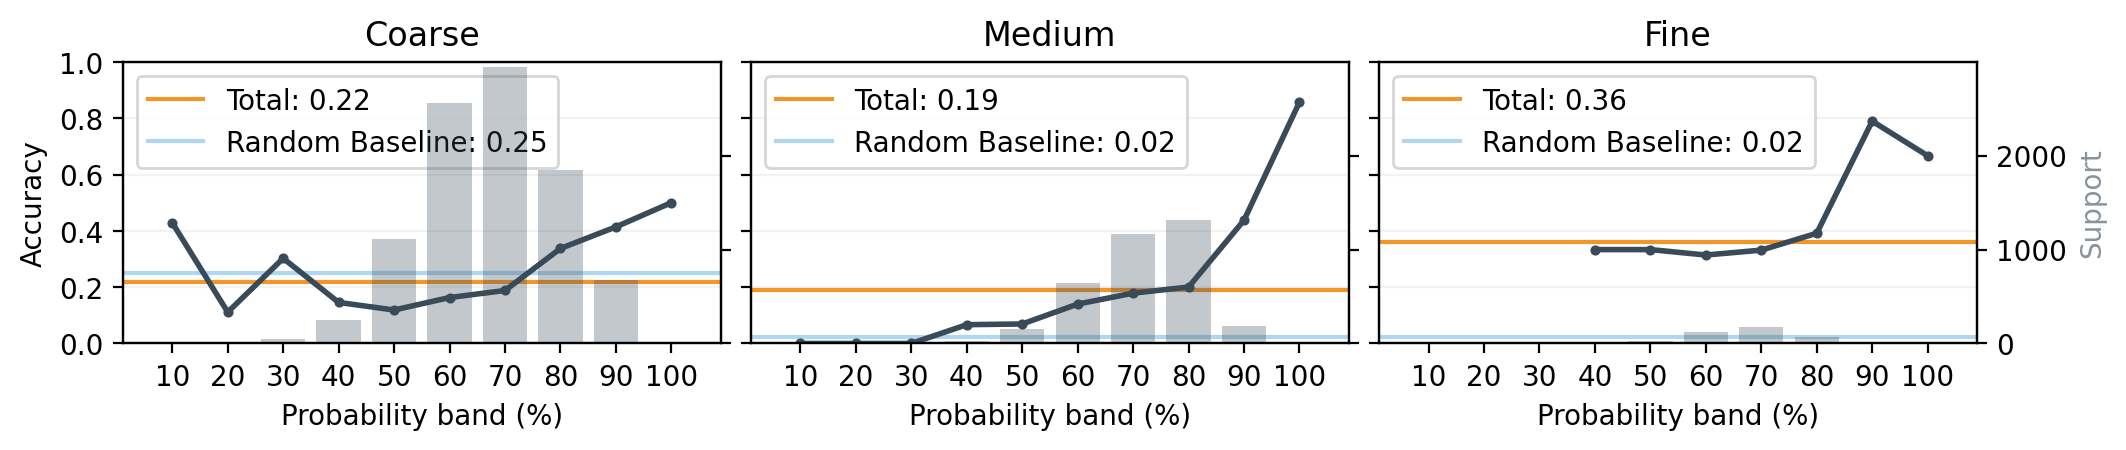

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(10, 2), dpi=200)
fig.tight_layout(w_pad=-2)
for i, ax in enumerate(axes):
    ax.plot(band_accuracy_at_granularity[i]['band'], band_accuracy_at_granularity[i]['accuracy'], color=color_palette('medium'), linewidth=2, zorder=3)
    ax.scatter(band_accuracy_at_granularity[i]['band'], band_accuracy_at_granularity[i]['accuracy'], color=color_palette('medium'), s=7, zorder=3)
    ax.set_title(granularities[i])
    ax.set_xlabel("Probability band (%)")
    ax.set_ylim(0, 1)
    ax.set_xticklabels(band_accuracy_at_granularity[i]['band'])

    ax.axhline(accuracy.loc[i, 'accuracy'], color=color_palette('accent'), label=f'Total: {accuracy.loc[i, "accuracy"]:.2f}', zorder=2)
    ax.axhline(1 / gran_types[i].shape[0], color=color_palette('light'), label=f'Random Baseline: {1 / gran_types[i].shape[0]:.2f}', zorder=2)

    # Draw a bar for the support
    ax2 = ax.twinx()
    ax2.bar(band_accuracy_at_granularity[i]['band'], band_accuracy_at_granularity[i]['support'], color=color_palette('medium'), alpha=0.3)
    ax2.set_ylim(0, 1.02 * max([band_accuracy_at_granularity[i]['support'].max() for i in range(3)]))

    if i != 2:
        ax2.set_yticklabels([])
    else:
        ax2.set_ylabel("Support", color=color_palette('medium'), alpha=0.6)

    ax.grid(axis='y', color=color_palette('bright'), zorder=0)

    # Show the legend on top of the other elements
    ax.legend(loc='upper left')

axes[0].set_ylabel("Accuracy")
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

fig.savefig(os.path.join(get_results_dir(), f'{MODEL}', f"{SPLIT}_accuracy_by_probability_band" + ("_ho" if HYPOTHESIS_ONLY else "") + '.png'), bbox_inches='tight')

### Sibling & Hypernym Probability

In [41]:
# Get the full_type and predicted type at each granularity
for i in [1, 2, 3]:
    # Get the ground truth type at the current granularity
    data_with_predictions[f'type_{i}'] = data_with_predictions['full_type'].apply(lambda x: get_type(x, granularity=i))

    # Get the predicted type at the current granularity
    data_with_predictions[f'predicted_type_{i}'] = data_with_predictions['predicted_type'].apply(lambda x: get_type(x, granularity=i))

    # Get the probability of the predicted type at the current granularity
    data_with_predictions[f'predicted_type_{i}_probability'] = data_with_predictions.apply(lambda row: row.get(get_type(row['predicted_type'], include_path=True, granularity=i)), axis=1)

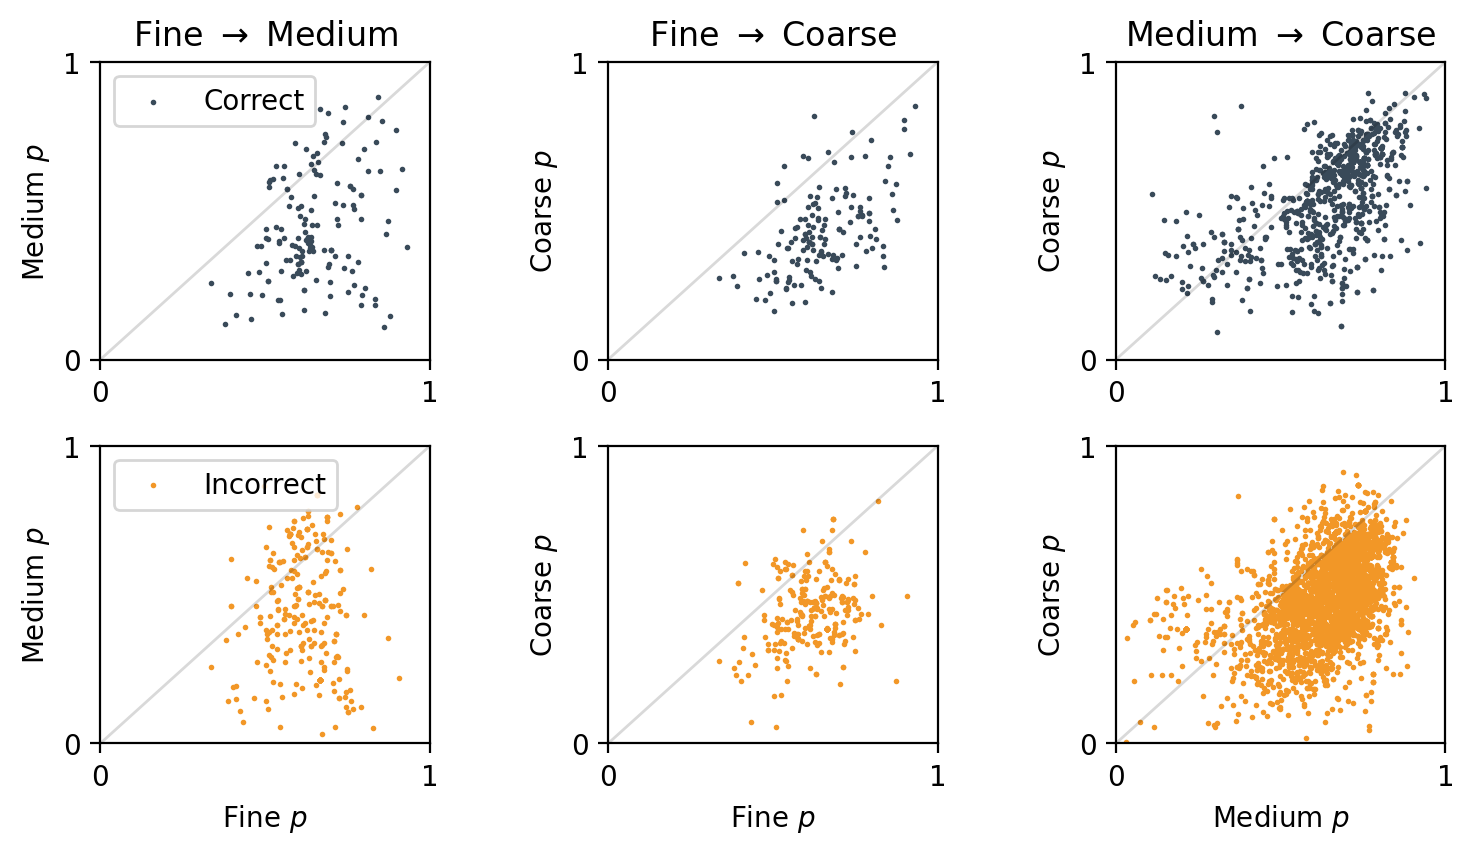

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(7.5, 4), dpi=200)
fig.tight_layout(w_pad=3, h_pad=1)
for i, (ax_row, color, mask, label) in enumerate(zip(axes, [color_palette('medium'), color_palette('accent')], [data_with_predictions['correct'].values, ~(data_with_predictions['correct'].astype(bool))], ['Correct', 'Incorrect'])):
    for j, (ax, (granularity_name, hypernym_granularity_name), (granularity, hypernym_granularity)) in enumerate(zip(ax_row, [('Fine', 'Medium'), ('Fine', 'Coarse'), ('Medium', 'Coarse')], [(3, 2), (3, 1), (2, 1)])):
        ax.scatter(data_with_predictions.loc[mask, f'predicted_type_{granularity}_probability'], data_with_predictions.loc[mask, f'predicted_type_{hypernym_granularity}_probability'], s=1, color=color, label=label)
        ax.plot([0, 1], [0, 1], color='k', linewidth=1, alpha=0.15)
        if i == 0:
            ax.set_title(f'{granularity_name} $\\rightarrow$ {hypernym_granularity_name}')
        if i == 1:
            ax.set_xlabel(f'{granularity_name} $p$')
        ax.set_ylabel(f'{hypernym_granularity_name} $p$')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        if j == 0:
            ax.legend(loc='upper left')

fig.savefig(os.path.join(get_results_dir(), f'{MODEL}', f"{SPLIT}_hypernym_probability" + ("_ho" if HYPOTHESIS_ONLY else "") + '.png'), bbox_inches='tight')

### Ferret

In [43]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from ferret import Benchmark
from nlinec.data.preprocessing import combine_premise_hypothesis, construct_hypothesis

In [44]:
if MODEL == 'roberta-large-mnli':
    model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(DEVICE)
else:
    model = AutoModelForSequenceClassification.from_pretrained(SAVE_MODEL_TO).to(DEVICE)
    
tokenizer = AutoTokenizer.from_pretrained('roberta-large-mnli')

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [45]:
bench = Benchmark(model, tokenizer)

In [46]:
def show_probabilities(index):
    granularity_colors = ['tab:blue', 'tab:orange', 'tab:green']
    granularity_labels = ['Coarse-grained', 'Medium-grained', 'Fine-grained']

    sentence = data_with_predictions.loc[index, 'sentence']
    mention_span = data_with_predictions.loc[index, 'mention_span']
    probabilities = data_with_predictions.loc[index, list(all_types['full_type'])].sort_index()
    # Sort the columns alphabetically
    probabilities

    # Split the plot over multiple columns
    N_COLS = 3
    type_per_col = len(probabilities)// N_COLS

    fig, axes = plt.subplots(1, N_COLS, figsize=(5 * N_COLS, 20 // N_COLS))
    fig.tight_layout(w_pad=18)
    fig.subplots_adjust(top=0.9)
    # Mark the mention in the sentence in red
    sentence = sentence.replace(mention_span, f'[[{mention_span}]]')
    fig.suptitle(sentence.replace('$', '\$'))

    for a, ax in enumerate(axes):
        start = a * type_per_col
        end = (a + 1) * type_per_col
        for i, (type_, probability) in enumerate(probabilities.iloc[start:end].items()):
            ax.barh(len(probabilities.iloc[start:end]) - i, probability, color=granularity_colors[get_granularity(type_) - 1])
        ax.set_yticks(np.arange(1, len(probabilities.iloc[start:end]) + 1))
        ax.set_yticklabels(probabilities.index[start:end][::-1])
        ax.set_ylim(0, len(probabilities.iloc[start:end]) + 1)
        ax.set_xlim(0, 1)
        ax.set_xlabel('Frequency')

    # Add a legend
    granularity_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in granularity_colors]
    axes[-1].legend(granularity_handles, granularity_labels, loc='upper right');

    return fig, axes